In [1]:
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import scipy.signal as signal
import winsound
import tikzplotlib


#FUNCION DETECTORA DE PICOS

def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array == lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not found!' if if_not_found == '' else if_not_found

    else:
        return match_value.tolist()[0]
    
    
#CARGA DE DATOS
D=50/1000 #Diametro de la parte cilindrica [m]
T=273.15+18
rho=PropsSI('D', 'T',T , 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu=PropsSI('V', 'T', T, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L=0.175*2 #Largo del cilindro en metros
A=D*L ## area proyectada

class medida:
    def __init__(self,direccion, espesor, largo):
        self.direccion = direccion
        self.espesor = espesor
        self.largo = largo
    
    def curva(self):
        a=str(str(self.direccion) + R"/e" + str(self.espesor) +R"/l"+str(self.largo))
        return a
    
#LECTURA DE DATOS
def analizadorCurva(carpeta):

    VelocityFile = "Velocidades Calibradas/Velocidades.txt"
    VelocityData = pd.read_csv(VelocityFile)
    PolinomioVelocidad=np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)

    RawDataFolder = str(carpeta)+"/"
    files = np.sort(glob.glob(RawDataFolder+'*.txt'))
    VoltajeMedicion=[]
    VelocidadMedicion=[]
    ReMedicion=[]
    for i in files:
        item=i[17:19]
        VoltajeMedicion.append(float(item))
        Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
        VelocidadMedicion.append(Vitem)
        ReMedicion.append(Vitem*D*rho/mu)

    Inicial= {
        "Voltaje" : VoltajeMedicion,
        "Velocidad" : VelocidadMedicion,
        "Re" : ReMedicion,
        }

    DFInicial = pd.DataFrame(Inicial)


    DFFinal=pd.DataFrame()
    for k in files:
        #Importo los datos y le saco datos de cabeza y de cola
        datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
        datos = datos[:-100]
        datos.columns = ["Time", "Frequency", "Drag", "Lift"]
        datos = datos.astype(float)
        datos=datos[800:2500]
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=(datos["Drag"].mean())
        stdDrag=(datos["Drag"].std())
        df=datos

        #Filtro para las cosas MUY gruesas por señales espurias, no se suele activar

        for i in df.index:
            #if df["Lift"][i]>(mediaLift+200*stdLift):
                #df["Lift"][i]=np.nan
            #if df["Lift"][i]<(mediaLift-200*stdLift):
                #df["Lift"][i]=np.nan
            if df["Drag"][i]>(mediaDrag+200*stdDrag):
                df["Drag"][i]=np.nan
            if df["Drag"][i]<(mediaDrag-200*stdDrag):
                df["Drag"][i]=np.nan
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=datos["Drag"].mean()
        stdDrag=datos["Drag"].std()   

        for i in df.index:
            #if df["Lift"][i]>(mediaLift+200*stdLift):
                #df["Lift"][i]=np.nan
            #if df["Lift"][i]<(mediaLift-200*stdLift):
                #df["Lift"][i]=np.nan
            if df["Drag"][i]>(mediaDrag+200*stdDrag):
                df["Drag"][i]=np.nan
            if df["Drag"][i]<(mediaDrag-200*stdDrag):
                df["Drag"][i]=np.nan
        mediaLift=datos["Lift"].mean()
        stdLift=datos["Lift"].std()
        mediaDrag=datos["Drag"].mean()
        stdDrag=datos["Drag"].std()

        df.interpolate(method ='linear', limit_direction ='backward', inplace=True)

        #LS para ver frecuencais
        tiempos=(df["Time"].values)/1000
        tiempos=tiempos-np.min(tiempos)
        fuerzas=df["Drag"].values
        fuerzas=fuerzas-np.mean(fuerzas)
        step=1/83.33
        w=np.linspace(1,2*np.pi*(1/step)*0.5,10000)
        pgram = signal.lombscargle(tiempos,fuerzas,w, normalize=True)

        dfLS=pd.DataFrame()
        dfLS["amp"]=pgram
        dfLS["frec"]=w/(2*np.pi)
        dfLS=dfLS.tail(8200)
        AmpDrag=(df["Drag"].max()-df["Drag"].min())/2
        frecpico=xlookup(dfLS["amp"].max(), dfLS["amp"], dfLS["frec"])


        vector = pd.DataFrame(np.array([[k],[mediaLift],[mediaDrag],[AmpDrag],[frecpico]]).T)
        DFFinal=pd.concat([DFFinal,vector], axis=0)

    DFFinal.rename(columns={0: 'txt', 1: 'MediaLift', 2: str("MediaDrag"), 3: str("AmpDrag"), 4: str("PicoDrag")}, inplace=True)
    DFFinal.reset_index(inplace=True)
    DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
    
    if carpeta[0:4]=="Drag":
        RawDataFolder = "RefSoporteDrag/"
    if carpeta[0:4]=="Lift":
        RawDataFolder = "RefSoporteLift/"
        
    files = np.sort(glob.glob(RawDataFolder+'*.txt'))
    VoltajeMedicion=[]
    VelocidadMedicion=[]
    ReMedicion=[]
    vector=[]
    for i in files:
        item=i[16:18]
        VoltajeMedicion.append(float(item))
        Vitem=PolinomioVelocidad[0]*float(item)+PolinomioVelocidad[1]
        VelocidadMedicion.append(Vitem)
        ReMedicion.append(Vitem*D*rho/mu)

    Inicial= {
        "Voltaje" : VoltajeMedicion,
        "Velocidad" : VelocidadMedicion,
        "Re" : ReMedicion,
        }
    DFInicial2 = pd.DataFrame(Inicial)
    DFFinal2 = pd.DataFrame()

    for k in files:
        datos = pd.read_csv(k, sep=",", header=None,skiprows=5)
        datos = datos[:-100]
        datos.columns = ["Time2", "Frequency2", "Drag2", "Lift2"]
        datos = datos.astype(float)
        datos=datos[800:3000]
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=(datos["Drag2"].mean())
        stdDrag=(datos["Drag2"].std())
        df=datos

        for i in df.index:
            #if df["Lift2"][i]>(mediaLift+200*stdLift):
                #df["Lift2"][i]=np.nan
            #if df["Lift2"][i]<(mediaLift-200*stdLift):
                #df["Lift2"][i]=np.nan
            if df["Drag2"][i]>(mediaDrag+200*stdDrag):
                df["Drag2"][i]=np.nan
            if df["Drag2"][i]<(mediaDrag-4*stdDrag):
                df["Drag2"][i]=np.nan
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=datos["Drag2"].mean()
        stdDrag=datos["Drag2"].std()   

        for i in df.index:
            #if df["Lift2"][i]>(mediaLift+200*stdLift):
                #df["Lift2"][i]=np.nan
            #if df["Lift2"][i]<(mediaLift-200*stdLift):
                #df["Lift2"][i]=np.nan
            if df["Drag2"][i]>(mediaDrag+200*stdDrag):
                df["Drag2"][i]=np.nan
            if df["Drag2"][i]<(mediaDrag-200*stdDrag):
                df["Drag2"][i]=np.nan
        mediaLift=datos["Lift2"].mean()
        stdLift=datos["Lift2"].std()
        mediaDrag=datos["Drag2"].mean()
        stdDrag=datos["Drag2"].std()   


        vector = pd.DataFrame(np.array([[k],[mediaLift],[mediaDrag]]).T)
        DFFinal2=pd.concat([DFFinal2,vector], axis=0)


    DFFinal2.rename(columns={0: 'txt', 1: 'MediaLift', 2: str("MediaDrag")}, inplace=True)
    DFFinal2.reset_index(inplace=True)
    DatosCD=pd.concat([DFFinal2,DFInicial2],axis =1)
    
    
    
    ## Tomo la referencia y la borro del original

    DatosCD=pd.concat([DFFinal,DFInicial],axis =1)
    DatosCD2=pd.concat([DFFinal2,DFInicial2],axis =1)

    Referencia=DatosCD[:1]
    Drag0=Referencia["MediaDrag"][0]
    #Lift0=Referencia["MediaLift"][0]
    DatosCD=DatosCD.drop([0]) 


    Referencia2=DatosCD2[:1]
    Drag02=Referencia2["MediaDrag"][0]
    #Lift02=Referencia2["MediaLift"][0]
    DatosCD2=DatosCD2.drop([0]) 

    DatosCD["Drag"]= DatosCD["MediaDrag"].astype(float)-float(Drag0)
    #DatosCD["Lift"]= DatosCD["MediaLift"].astype(float)-float(Lift0)

    DatosCD2["Drag"]= DatosCD2["MediaDrag"].astype(float)-float(Drag02)
    #DatosCD2["Lift"]= DatosCD2["MediaLift"].astype(float)-float(Lift02)

    DatosCD["Drag"]= DatosCD["Drag"]-DatosCD2["Drag"]
    #DatosCD["Lift"]= DatosCD["Lift"]-DatosCD2["Lift"]
    DatosCD["St"]=D*DatosCD["PicoDrag"].astype(float)/DatosCD["Velocidad"].astype(float)
    DatosCD["AmpDrag"]=DatosCD["AmpDrag"].astype(float)*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])


    DatosCD=DatosCD.drop("txt", axis=1)
    DatosCD=DatosCD.drop("MediaDrag", axis=1)
    DatosCD=DatosCD.drop("MediaLift", axis=1)
    DatosCD=DatosCD.drop("index", axis=1)

    DatosCD[str("C"+carpeta[0])]=DatosCD["Drag"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])
    #DatosCD["CL"]=DatosCD["Lift"]*0.00980665/(0.5*A*rho*DatosCD["Velocidad"]*DatosCD["Velocidad"])    
    
    
    
    
    
    
    
    
    return DatosCD
    

In [2]:
a=medida("Drag", "000", "0000")
aa=medida("Lift", "000", "0000")

c1=analizadorCurva(a.curva())
c2=analizadorCurva(aa.curva())

a=c1["Re"].values
b=c1["CD"].values
c=c1["St"].values
d=(c2["CL"]-c2["CL"].mean()).values
f=c2["St"].values

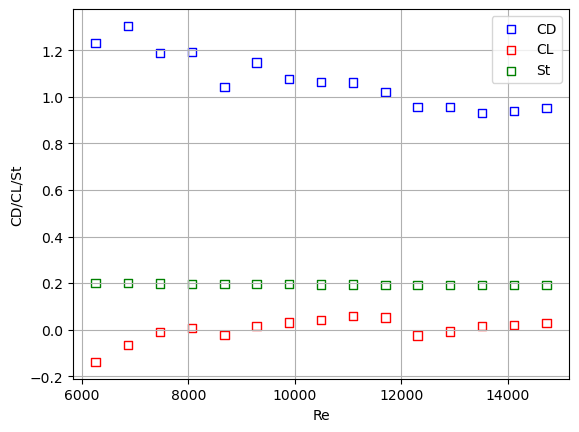

In [3]:
#fig, (ax1) = plt.subplots(1, 1)
plt.clf ()


CD = plt.scatter(a,b, marker="s", edgecolor="blue",facecolors="none")
CL = plt.scatter(a,d, marker="s", edgecolor="red",facecolors="none")
St = plt.scatter(a,c, marker="s", edgecolor="green",facecolors="none")

plt.grid("on")

plt.legend((CD,CL,St),("CD","CL","St"))

plt.xlabel("Re")


plt.ylabel("CD/CL/St")


tikzplotlib.save("triple.tex")

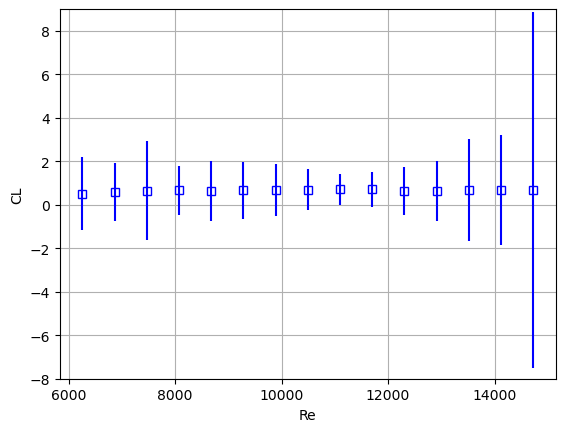

In [4]:
a=medida("Lift", "000", "0000")
c1=analizadorCurva(a.curva())
a=c1["Re"].values
b=c1["CL"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CL")

plt.ylim(bottom=-8)
plt.ylim(top=9)
plt.grid()



plt.errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="s",markerfacecolor='none', linestyle="none", color="blue")
tikzplotlib.save("CLvsRePrueba.tex")

In [5]:
c1

,AmpDrag,PicoDrag,Voltaje,Velocidad,Re,Drag,St,CL
1,1.665525,29.660309140456224,22.0,1.893095,6257.023807,1.979740,0.783381,0.517225
2,1.316402,8.145678184365142,24.0,2.076108,6861.914695,2.718420,0.196177,0.590517
3,2.278550,17.759393271053728,26.0,2.259121,7466.805582,3.512504,0.393060,0.644397
4,1.117782,9.577773048314867,28.0,2.442134,8071.696470,4.223202,0.196094,0.663008
5,1.363409,40.93442406940536,30.0,2.625147,8676.587358,4.652512,0.779660,0.632115
6,1.304878,21.835674883803378,32.0,2.808159,9281.478246,5.664591,0.388790,0.672575
7,1.207120,11.578554858238832,34.0,2.991172,9886.369133,6.558585,0.193545,0.686346
8,0.952987,12.284224791199563,36.0,3.174185,10491.260021,7.496788,0.193502,0.696669
9,0.701555,12.927629730075527,38.0,3.357198,11096.150909,8.584636,0.192536,0.713155
10,0.821023,13.562732669740187,40.0,3.540211,11701.041796,9.481423,0.191553,0.708323


In [6]:
espesores = ["030", "075", "100", "175", "999"]
largos = ["0250", "0375", "0500", "0625", "0750"]




In [7]:
espesores[1]

'075'

In [8]:
largos[1]

'0375'

In [9]:
df_col_merged=pd.DataFrame()

for i in espesores:
    for j in largos:
        c1=analizadorCurva(medida("Drag", i, j).curva())
        c2=analizadorCurva(medida("Lift", i, j).curva())

        
        c1["Espesor"]=i
        c1["Largo"]=j
        
        c1["Lift"]=c2["Drag"]
        c1["CL"]=c2["CL"]
        c1["St Lift"] = c2["St"]
        c1["St Drag"] = c1["St"]
        c1["AmpLift"] = c2["AmpDrag"]
        c1["PicoLift"] = c2["PicoDrag"]

        df_col_merged = pd.concat([df_col_merged, c1], axis=0)



In [10]:
c1=analizadorCurva(medida("Drag", "000", "0000").curva())
c2=analizadorCurva(medida("Lift", "000", "0000").curva())


c1["Espesor"]="000"
c1["Largo"]="0000"

c1["Lift"]=c2["Drag"]
c1["CL"]=c2["CL"]
c1["St Lift"] = c2["St"]
c1["St Drag"] = c1["St"]
c1["AmpLift"] = c2["AmpDrag"]
c1["PicoLift"] = c2["PicoDrag"]

df_col_merged = pd.concat([df_col_merged, c1], axis=0)
df_col_merged = df_col_merged.applymap (float)

df_col_merged=df_col_merged.round(decimals = 2)
df_col_merged["Re"]=df_col_merged["Re"].round(decimals = 0)

In [11]:
df_col_merged["Espesores"] = df_col_merged["Espesor"]/1000000
df_col_merged["Largo"] = df_col_merged["Largo"]/10000

In [12]:
df_col_merged.to_csv("datosSin0.csv", sep=";", decimal=',')

In [13]:
df_col_merged

,AmpDrag,PicoDrag,Voltaje,Velocidad,Re,Drag,St,CD,Espesor,Largo,Lift,CL,St Lift,St Drag,AmpLift,PicoLift,Espesores
1,0.54,7.63,22.0,1.89,6257.0,5.81,0.20,1.52,30.0,0.025,4.36,1.14,0.20,0.20,1.68,7.68,0.00003
2,0.38,8.30,24.0,2.08,6862.0,6.68,0.20,1.45,30.0,0.025,5.24,1.14,0.20,0.20,1.46,8.34,0.00003
3,0.41,9.06,26.0,2.26,7467.0,7.59,0.20,1.39,30.0,0.025,5.92,1.09,0.20,0.20,1.47,9.08,0.00003
4,0.41,9.73,28.0,2.44,8072.0,8.11,0.20,1.27,30.0,0.025,7.01,1.10,0.39,0.20,1.30,18.83,0.00003
5,0.26,10.40,30.0,2.63,8677.0,8.32,0.20,1.13,30.0,0.025,7.96,1.08,0.36,0.20,0.99,18.79,0.00003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.33,14.32,42.0,3.72,12306.0,14.18,0.19,0.96,0.0,0.000,9.34,0.63,0.19,0.19,1.09,14.27,0.00000
12,0.19,14.96,44.0,3.91,12911.0,15.60,0.19,0.96,0.0,0.000,10.56,0.65,0.19,0.19,1.37,14.90,0.00000
13,0.15,15.70,46.0,4.09,13516.0,16.60,0.19,0.93,0.0,0.000,12.01,0.67,0.19,0.19,2.36,15.64,0.00000
14,0.20,16.36,48.0,4.27,14121.0,18.31,0.19,0.94,0.0,0.000,13.19,0.68,0.19,0.19,2.51,16.34,0.00000


In [14]:
df_col_merged["Inercia"]= (2*0.175* df_col_merged["Espesores"]**3)/12
df_col_merged["Masa x unidad de area"] = 2*0.175* df_col_merged["Espesores"] * 1455
df_col_merged["Young"] = 0.5 * (2800 + 3100) * 1000000

In [15]:
lam=4.73004074

In [16]:
df_col_merged["Frecuencia Propia 1"] = (lam * lam * (df_col_merged["Young"]*df_col_merged["Inercia"]/df_col_merged["Masa x unidad de area"] )**0.5)/(2 * np.pi * df_col_merged["Largo"]**2)

In [17]:
lam=7.85320462
df_col_merged["Frecuencia Propia 2"] = (lam * lam * (df_col_merged["Young"]*df_col_merged["Inercia"]/df_col_merged["Masa x unidad de area"] )**0.5)/(2 * np.pi * df_col_merged["Largo"]**2)

In [18]:
lam=10.9956078
df_col_merged["Frecuencia Propia 3"] = (lam * lam * (df_col_merged["Young"]*df_col_merged["Inercia"]/df_col_merged["Masa x unidad de area"] )**0.5)/(2 * np.pi * df_col_merged["Largo"]**2)

In [19]:
lam=14.1371635
df_col_merged["Frecuencia Propia 4"] = (lam * lam * (df_col_merged["Young"]*df_col_merged["Inercia"]/df_col_merged["Masa x unidad de area"] )**0.5)/(2 * np.pi * df_col_merged["Largo"]**2)

In [20]:
df_col_merged["Frecuencia Adimensional 1"] = df_col_merged["Frecuencia Propia 1"] / df_col_merged["PicoLift"]
df_col_merged["Frecuencia Adimensional 2"] = df_col_merged["Frecuencia Propia 2"] / df_col_merged["PicoLift"]
df_col_merged["Frecuencia Adimensional 3"] = df_col_merged["Frecuencia Propia 3"] / df_col_merged["PicoLift"]
df_col_merged["Frecuencia Adimensional 4"] = df_col_merged["Frecuencia Propia 4"] / df_col_merged["PicoLift"]
df_col_merged["Relacion de aspecto"] = df_col_merged["Largo"]/ df_col_merged["Espesores"]
df_col_merged["Ca"] = (df_col_merged["Velocidad"]**2 * 1.2 * df_col_merged["Largo"]**3)/(df_col_merged["Young"]*df_col_merged["Inercia"])

In [68]:
df_col_merged.to_excel("datos.xlsx")

C:\Users\Santi\AppData\Local\Temp\ipykernel_28168\772326445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ca"]=df["Ca"]


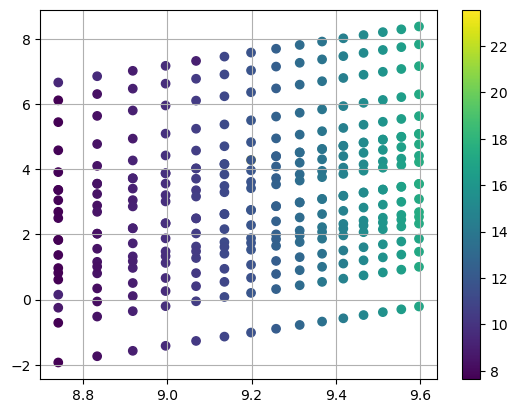

In [55]:
df=df_col_merged[df_col_merged["Espesor"]!=0]
df=df_col_merged[df_col_merged["Espesor"]!=999]

df["Ca"]=df["Ca"]

plt.scatter(np.log(df['Re']),np.log(df["Ca"]), c=df["PicoDrag"], cmap = "viridis")
plt.colorbar()

plt.grid("on")
plt.show()


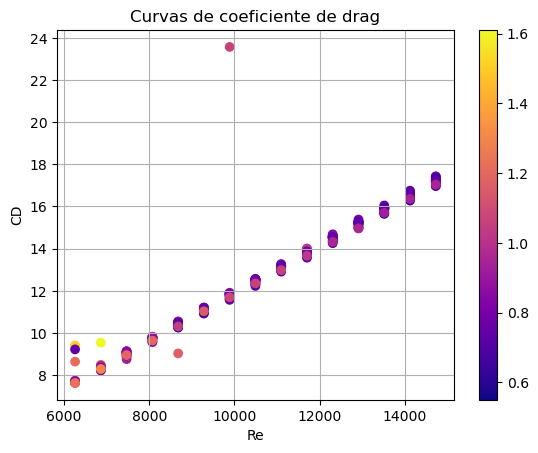

In [66]:
plt.scatter((df['Re']),df["PicoDrag"], c=df["CD"], cmap = "plasma", marker="o")
plt.colorbar()
plt.grid("on")

plt.xlabel('Re')
plt.ylabel('CD')
plt.title('Curvas de coeficiente de drag')


plt.show()

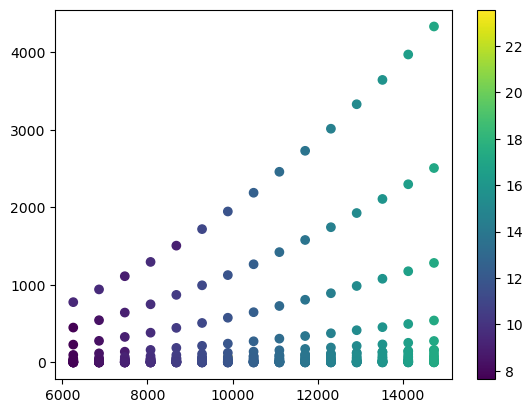

In [46]:
plt.scatter((df['Re']),(df["Ca"]), c=df["PicoDrag"], cmap = "viridis")
plt.colorbar()
plt.show()

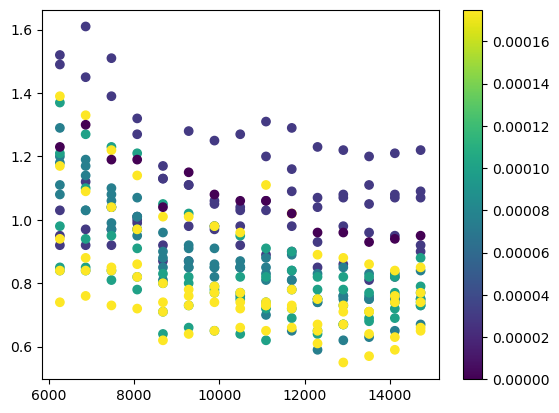

In [45]:
df=df_col_merged[df_col_merged["Espesor"]!=999]

plt.scatter(df['Re'],df["CD"], c=df["Espesores"], cmap = "viridis")
plt.colorbar()
plt.show()

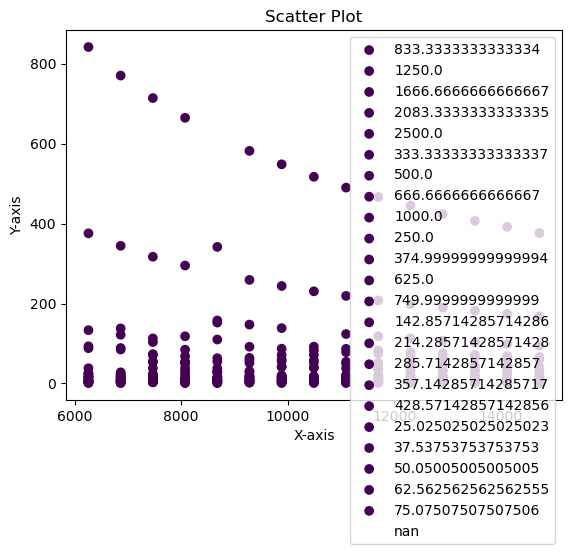

In [25]:
fig, ax = plt.subplots()

for color in df_col_merged["Relacion de aspecto"].unique():
    subset = df_col_merged[df_col_merged["Relacion de aspecto"] == color]
    ax.scatter(subset['Re'], subset["Frecuencia Adimensional 2"], c=subset["Relacion de aspecto"], label=color)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()

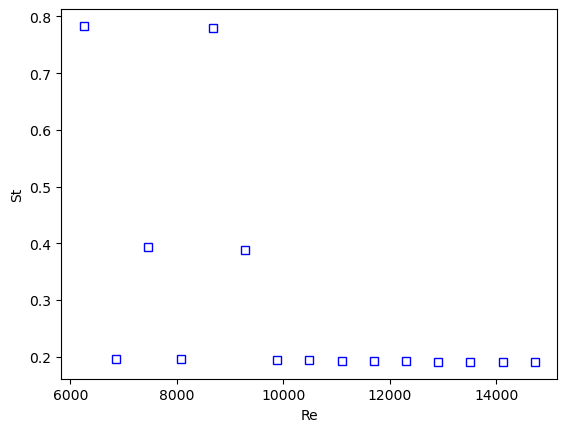

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a,c, marker="s", color="blue", markerfacecolor='none', linestyle="none")
ax1.set_xlabel("Re")
ax1.set_ylabel("St")
tikzplotlib.save("StvsRePrueba.tex")

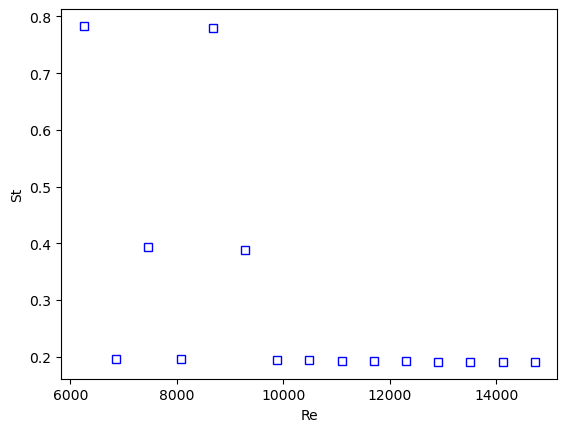

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a,c, marker="s", color="blue", markerfacecolor='none', linestyle="none")
ax1.set_xlabel("Re")
ax1.set_ylabel("St")
tikzplotlib.save("StvsRePrueba.tex")

<ErrorbarContainer object of 3 artists>

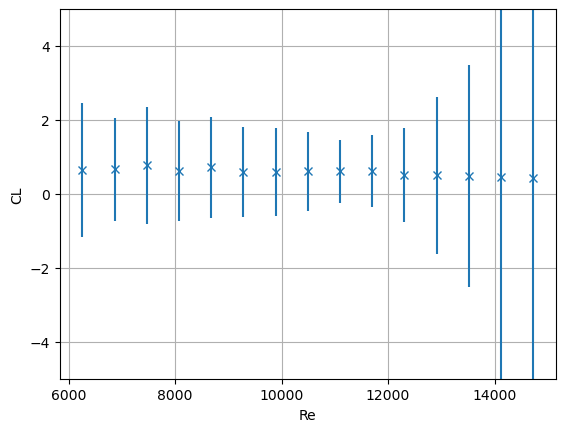

In [28]:
a=medida("Lift", "175", "0750")
c1=analizadorCurva(a.curva())
a=c1["Re"].values
b=c1["CL"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CL")

plt.ylim(bottom=-5)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="x",label="25mm")

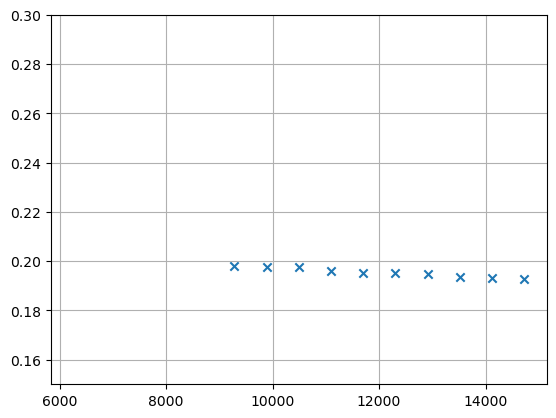

In [29]:
plt.scatter(a, c, marker="x")

plt.ylim(bottom=0.15)
plt.ylim(top=0.3)
plt.grid()


In [30]:
a=medida("Lift", "000", "0000")
c1=analizadorCurva(a.curva())

In [31]:
c1

,AmpDrag,PicoDrag,Voltaje,Velocidad,Re,Drag,St,CL
1,1.665525,29.660309140456224,22.0,1.893095,6257.023807,1.979740,0.783381,0.517225
2,1.316402,8.145678184365142,24.0,2.076108,6861.914695,2.718420,0.196177,0.590517
3,2.278550,17.759393271053728,26.0,2.259121,7466.805582,3.512504,0.393060,0.644397
4,1.117782,9.577773048314867,28.0,2.442134,8071.696470,4.223202,0.196094,0.663008
5,1.363409,40.93442406940536,30.0,2.625147,8676.587358,4.652512,0.779660,0.632115
6,1.304878,21.835674883803378,32.0,2.808159,9281.478246,5.664591,0.388790,0.672575
7,1.207120,11.578554858238832,34.0,2.991172,9886.369133,6.558585,0.193545,0.686346
8,0.952987,12.284224791199563,36.0,3.174185,10491.260021,7.496788,0.193502,0.696669
9,0.701555,12.927629730075527,38.0,3.357198,11096.150909,8.584636,0.192536,0.713155
10,0.821023,13.562732669740187,40.0,3.540211,11701.041796,9.481423,0.191553,0.708323


In [32]:
a=medida("Lift", "075", "0250")
b=medida("Lift", "075", "0375")
c=medida("Lift", "075", "0500")
d=medida("Lift", "075", "0625")
e=medida("Lift", "075", "0750")

In [33]:
c1=analizadorCurva(a.curva())
c2=analizadorCurva(b.curva())
c3=analizadorCurva(c.curva())
c4=analizadorCurva(d.curva())
c5=analizadorCurva(e.curva())

duration = 3000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

NameError: name 'tit' is not defined

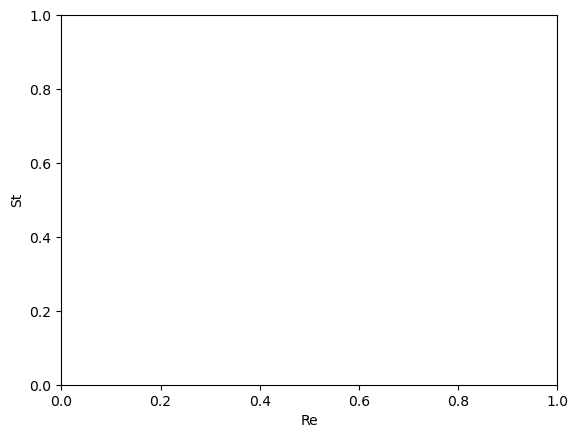

In [34]:
plt.xlabel("Re")
plt.ylabel("St")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=0.4)
plt.grid()

plt.scatter(a, c,label="75mm", marker="x")


plt.legend(loc="upper left")

In [ ]:
espesores = ["075"]#["030", "075", "100", "175", "999"]
largos = ["0250","0375","0500","0625","0750"]
for i in espesores:
    figure,axis = plt.subplots(1,2)
    plt.title(i)
    for j in largos:
        curva=medida("Lift", i, j)
        c1=analizadorCurva(curva.curva())
        a=c1["Re"].values
        b=c1["CL"].values
        c=c1["St"].values


        axis[0].set_xlabel("Re")
        axis[1].set_xlabel("Re")
        axis[0].set_ylabel("CL")
        axis[1].set_ylabel("St")

        plt.grid()
        
        axis[0].errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="x",label=i)
        axis[1].scatter(a, c,label=j, marker="x")
        plt.legend(loc="upper left")
        plt.savefig(i+".png");
    plt.savefig(i+".png");
    plt.show()




    
        

In [ ]:
i

In [ ]:
j

In [ ]:
a=medida("Lift", "000", "0000")
c1=analizadorCurva(a.curva())
a=c1["Re"].values
b=c1["CL"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CL")

plt.ylim(bottom=-10)
plt.ylim(top=10)
plt.grid()



plt.errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="x",label="25mm")

In [ ]:
tit="PET 175um"
#DatosCD.plot.scatter(x="Re", y="CD")
a=c1["Re"].values
b=c1["CD"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c1["AmpDrag"]).values, fmt="x",label="25mm")


a=c2["Re"].values
b=c2["CD"].values
c=c2["St"].values


#plt.scatter(a, b, color="red",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c2["AmpDrag"]).values, fmt="x",label="37.5mm")

a=c3["Re"].values
b=c3["CD"].values
c=c3["St"].values


#plt.scatter(a, b, color="yellow",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c3["AmpDrag"]).values, fmt="x",label="50mm")

a=c4["Re"].values
b=c4["CD"].values
c=c4["St"].values


#plt.scatter(a, b, color="green",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.errorbar(a, b, yerr=(c4["AmpDrag"]).values, fmt="x",label="62.5mm")



a=c5["Re"].values
b=c5["CD"].values
c=c5["St"].values


plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=3)
plt.grid()

plt.errorbar(a, b, yerr=(c5["AmpDrag"]).values, fmt="x",label="75mm")


plt.legend(loc="upper left")
plt.savefig(tit+".png");


In [ ]:
tit="PET 175um"
#DatosCD.plot.scatter(x="Re", y="CD")
a=c1["Re"].values
b=c1["CD"].values
c=c1["St"].values


#plt.scatter(a, b, color="blue",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="25mm", marker="x")


a=c2["Re"].values
b=c2["CD"].values
c=c2["St"].values


#plt.scatter(a, b, color="red",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="37.5mm", marker="x")

a=c3["Re"].values
b=c3["CD"].values
c=c3["St"].values


#plt.scatter(a, b, color="yellow",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="50mm", marker="x")

a=c4["Re"].values
b=c4["CD"].values
c=c4["St"].values


#plt.scatter(a, b, color="green",label="25mm")
plt.xlabel("Re")
plt.ylabel("CD")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=5)
plt.grid()



plt.scatter(a, c,label="62.5mm", marker="x")



a=c5["Re"].values
b=c5["CD"].values
c=c5["St"].values


plt.xlabel("Re")
plt.ylabel("St")
plt.title(tit)
plt.ylim(bottom=0)
plt.ylim(top=0.4)
plt.grid()

plt.scatter(a, c,label="75mm", marker="x")


plt.legend(loc="upper left")

In [35]:
df_col_merged

,AmpDrag,PicoDrag,Voltaje,Velocidad,Re,Drag,St,CD,Espesor,Largo,...,Frecuencia Propia 1,Frecuencia Propia 2,Frecuencia Propia 3,Frecuencia Propia 4,Frecuencia Adimensional 1,Frecuencia Adimensional 2,Frecuencia Adimensional 3,Frecuencia Adimensional 4,Relacion de aspecto,Ca
1,0.54,7.63,22.0,1.89,6257.0,5.81,0.20,1.52,30.0,0.025,...,70.25545,193.661854,379.654663,627.588272,9.147845,25.216387,49.434201,81.717223,833.333333,28.830508
2,0.38,8.30,24.0,2.08,6862.0,6.68,0.20,1.45,30.0,0.025,...,70.25545,193.661854,379.654663,627.588272,8.423915,23.220846,45.522142,75.250392,833.333333,34.918483
3,0.41,9.06,26.0,2.26,7467.0,7.59,0.20,1.39,30.0,0.025,...,70.25545,193.661854,379.654663,627.588272,7.737384,21.328398,41.812188,69.117651,833.333333,41.223567
4,0.41,9.73,28.0,2.44,8072.0,8.11,0.20,1.27,30.0,0.025,...,70.25545,193.661854,379.654663,627.588272,3.731038,10.284751,20.162223,33.329170,833.333333,48.051655
5,0.26,10.40,30.0,2.63,8677.0,8.32,0.20,1.13,30.0,0.025,...,70.25545,193.661854,379.654663,627.588272,3.738981,10.306645,20.205144,33.400121,833.333333,55.826473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.33,14.32,42.0,3.72,12306.0,14.18,0.19,0.96,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.19,14.96,44.0,3.91,12911.0,15.60,0.19,0.96,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.15,15.70,46.0,4.09,13516.0,16.60,0.19,0.93,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.20,16.36,48.0,4.27,14121.0,18.31,0.19,0.94,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
